# Korean vishing Detection using KoBERT model from HuggingFace on TensorFlow

## Install dependencies

Install the tensorFlow to work on GPU for WSL2 Ubuntu 20.04 LTS (Focal Fossa) on Windows 11 Pro as follows described in the [TensorFlow documentation](https://www.tensorflow.org/install/pip#windows-wsl2).
1. Install WSL2
2. Install the NVIDIA drive
3. NVIDIA’s setup docs for CUDA in WSL2
4. Install TensorFlow
5. Verify the installation
6. Install the transformers library
7. Install the pandas library
8. Install the numpy library
9. Install the scikit-learn library
10. Install the matplotlib library
11. Install the seaborn library
(optional)
12. Install the tqdm library
13. Install the sentencepiece library
14. Install the pydot library
15. Install the graphviz library

In [5]:
# Verify the installation:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Check if TensorFlow is using GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Num GPUs Available:  0
Num GPUs Available:  0
Please install GPU version of TF


In [10]:
!pip install transformers pandas numpy


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/b7/3f/945ef7ab14dc4f9d7f40288d2df998d1837ee0888ec3659c813487572faa/pip-25.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 1.4 MB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.8 MB 4.6 MB/s eta 0:00:01
   -------------------------- ------------- 1.2/1.8 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 12.4 MB/s eta 0:00:00


ERROR: To modify pip, please run the following command:
C:\Users\hye42\Korean_Voice_Phishing_Detection\venv\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
!pip install tensorflow
!pip3 install tensorflow[and-cuda]


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for nvidia-cublas-cu12==12.5.3.2 from https://files.pythonhosted.org/packages/50/18/d32d9ea61a6df42b3887b4a8acb6edcf81bd2cf787c8dbf759f1e63f1414/nvidia_cublas_cu12-12.5.3.2-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for nvidia-cuda-cupti-cu12==12.5.82 from https://files.pythonhosted.org/packages/7a/11/56bd2b1e7c12f03bf60f6ac37be3a8c8f020803bee46888d768d94ca7c2f/nvidia_cuda_cupti_cu12-12.5.82-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for nvidia-cuda-nvcc-cu12==12.5.82 from https://files.pythonhosted.org/packages/91/c2/8c80e81aa1bb59bf7b1260cc62c1c58759a540331a006d84b96f428c7437/nvidia_cuda_nvcc_cu12-12.5.82-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for nvidia-cuda-nvrtc-cu12==12.5.82 from https://files.pythonhosted.org/packages/46/3f/a45978aeef7d08432c678cd0ca40f56e14e856fd3023d6e5e94bf84ffc8d/nvidia_cuda_nvrtc_cu12-12.5.82-py3-none-win_amd64.whl.metadata
  Obtaining dependency i

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\hye42\\Korean_Voice_Phishing_Detection\\venv\\Lib\\site-packages\\google\\~upb\\_message.pyd'
Check the permissions.


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# load the libraries
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification ,TFBertModel, AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from transformers import AdamWeightDecay
import pandas as pd
import numpy as np
import re, os, time, gc, psutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from keras.utils import to_categorical
from transformers import AdamW
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.optimizers import AdamW,
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.utils import to_categorical

ImportError: cannot import name 'AdamW' from 'transformers' (C:\Users\hye42\Korean_Voice_Phishing_Detection\venv\Lib\site-packages\transformers\__init__.py)

## Load the dataset and cleaning

In [16]:
# Import the dataset KorCCVi
df = pd.read_csv('KorCCVi_v2.csv')
# df = pd.read_csv('KorCCViD_v1.3_fullcleansed.csv')
df.head()

,id,transcript,confidence,label
0,0,저는 여행 다니는 것을 굉장히 좋아하는데요. 그래가지고 스페인이나 뭐 영국 유럽 아...,NaN,0
1,1,반려동물을 키우고 계신가요? 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보...,NaN,0
2,2,씨는 주로 어떤 음식 좋아하시나요? 저는 근데 가리는 게 거의 없어서 대부분 다 ...,NaN,0
3,3,씨는 반려동물 어~ 좋 뭐 어떤 동물 좋아하세요? 저는 고양이를 정말 좋아하는데요...,NaN,0
4,4,가장 좋아하는 음식이 무엇인가요? 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고...,NaN,0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          2927 non-null   int64  
 1   transcript  2927 non-null   object 
 2   confidence  0 non-null      float64
 3   label       2927 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 91.6+ KB


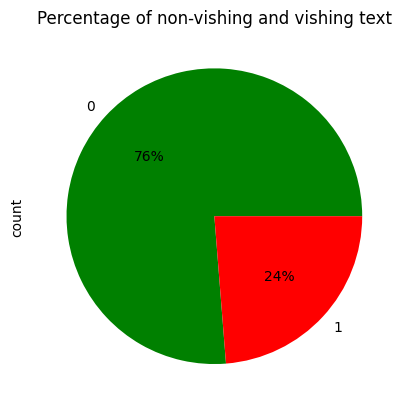

In [18]:
# visualize the dataset with pie chart 
df['label'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['green', 'red'])
plt.title('Percentage of non-vishing and vishing text')
plt.show()

In [19]:
# function to plot the class distribution
def plot_class_distribution(data, title):
    sns.set(style="whitegrid")
    # sns.set(style="ticks")
    ax = sns.countplot(x='label', data=data)
    ax.set_title(title)
    
    # Annotate the bars with the number of samples
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        
    plt.show()

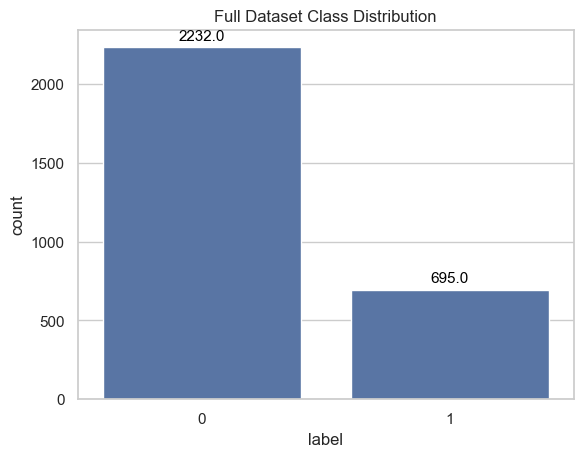

In [20]:
# drop the colum we don't need
df.drop(['confidence'], axis=1, inplace=True)
plot_class_distribution(df, 'Full Dataset Class Distribution')

In [21]:
# function to perform the cleaning parts
def apply_replacement(src_df, replace_func):
    ret_df = src_df
    ret_df['transcript'] = ret_df['transcript'].apply(lambda x: replace_func(x))
    return ret_df

In [22]:
# remove the unwanted word and characters from the dataset
def word_replace(x):
    example_word_replace_list = {'o/': '',
                                 'b/': '',
                                'n/': '',
                                '\n': ' ',
                                'name': '',
                                'laughing': '',
                                'clearing': '',
                                'singing': '',
                                'applauding': ''}

    for i in example_word_replace_list:
        x = x.replace(i, example_word_replace_list[i])
    return x

In [23]:
# remove the special character from the transcripts
def remove_special_characters(sentence):
    sentence = re.sub(r"[^a-zA-Z0-9ㄱ-ㅣ가-힣]", ' ', sentence)
    sentence = re.sub(r"[-~=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]", '', sentence)
    return sentence

In [24]:
# remove x and O from the transcripts
def remove_x_o(sentence):
    sentence = re.sub(r"[xX]", '', sentence)
    sentence = re.sub(r"[oO]", '', sentence)
    sentence = re.sub(r"(o|O|\ㅇ|0|x){2,}", '', sentence)
    return sentence

In [25]:
# remove all the digits and numbers from the transcripts
def remove_digits(sentence):
    sentence = re.sub(r"[0-9]", '', sentence)
    return sentence

In [26]:
# remove all extra spaces from the transcripts
def remove_extra_spaces(sentence):
    sentence = re.sub(r"\s+", ' ', sentence)
    return sentence

In [27]:
# Apply all the cleaning functions to the dataset
df = apply_replacement(df, word_replace)
df = apply_replacement(df, remove_special_characters)
df = apply_replacement(df, remove_x_o)
df = apply_replacement(df, remove_digits)
df = apply_replacement(df, remove_extra_spaces)

In [28]:
# print the row with any English character in the transcript
print(df[df['transcript'].str.contains('[a-zA-Z]')].head(5))

        id                                         transcript  label
69      69  네 씨는 혹시 여행 좋아하시나요 저는 되게 많이 좋아합니다 국내 해외 다 좋아하고 ...      0
1168  1168  언니 요새 이가 여자 친구한테 선물 받은 거 있어 있긴 있는 거 같더라고 그렇지 않...      0
1452  1452  나는 지금 강아지를 년째 키우고 있는 중이거든 우리 강아지 이름은 코난이고 아 얘가...      0
2233  2233  본인 성함 알겟습니다 제가 첫번째는 이제 본인이 혹시라도 이제 깡통 계좌 발생으로 ...      1
2239  2239  보니까 서면조사를 받으셔야 되고요 알겠습니다 그럼 말씀 드릴게요 계속 말씀드렸다시피...      1


In [29]:
# save the cleaned dataset
df.to_csv('KorCCVi_v2_cleaned.csv', index=False)

## Training the KoBERT model using the Tokenizer provided by KoBERT

In [30]:
# Load the cleaned dataset
df = pd.read_csv('KorCCVi_v2_cleaned.csv')

In [31]:
sentences = df['transcript'].values
labels = df['label'].values

### Tokenization & Input Formatting Method 1

In [32]:
# Load the KoBERT tokenizer
# tokenizer = BertTokenizer.from_pretrained("kykim/bert-kor-base")
# tokenizer = BertTokenizer.from_pretrained('monologg/kobert')

In [33]:
# # Tokenize the input texts
# def convert_example_to_feature(review):
#     return tokenizer.encode_plus(review, 
#                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                                  max_length = None,           # 64, 512, None, max_length, Pad & truncate all sentences 
#                                  # pad_to_max_length = True,
#                                  padding='max_length',        # True, longest, max_length, Pad & truncate all sentences
#                                  return_attention_mask = True,
#                                  return_token_type_ids = False,
#                                  truncation=True)

In [34]:
# # Map to the expected input to TFBertForSequenceClassification, see https://huggingface.co/transformers/model_doc/bert.html#tfbertforsequenceclassification
# input_ids = []
# attention_masks = []

In [35]:
# for sent in sentences:
#     encoded_dict = convert_example_to_feature(sent)
#     input_ids.append(encoded_dict['input_ids'])
#     attention_masks.append(encoded_dict['attention_mask'])

In [36]:
# # # Print the shapes of the data.
# print('Original: ', sentences[0])
# print('Token IDs:', input_ids[0])

In [37]:
# # Convert the lists into tensors.
# # input_ids = tf.convert_to_tensor(input_ids)
# # attention_masks = tf.convert_to_tensor(attention_masks)
# # labels = tf.convert_to_tensor(labels)
# 
# input_ids = tf.constant(input_ids)
# attention_masks = tf.constant(attention_masks)
# labels = tf.constant(labels)

In [38]:
# input_ids

In [39]:
# labels

In [40]:
# attention_masks

In [41]:
# # split the dataset into train, validation and test set
# # train_ratio = 0.7
# # validation_ratio = 0.15
# # test_ratio = 0.15
# #     
# # train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)
# # train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
# # train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.2)
# # Split data into train and validation sets
# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
# train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1)

### Split the dataset

In [42]:
# Split data into training and testing sets
# train_inputs, validation_inputs, train_inputs, validation_labels = train_test_split(sentences, labels, random_state=2018, test_size=0.2)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2)

In [43]:
X_train

array(['가족의 의미는 어떤 거 같아 가족의 의미는 되게 소중한 사람들 같아 가족이라는 거는 한 명 한 명이 모여가지고 혈연이라는 것도 있지만은 혈연을 넘어서 그냥 피가 섞였다는 그런 거 말고도 되게 소중한 사람들 있으니까 힘이 나고 오늘 아버지께서 아침에 말씀하신 거처럼 너희가 있어서 힘이 난다는 거처럼 가족이라는 거는 되게 힘이 되는 주는 존재 존재 같아 그래서 피가 섞였다는 것도 되게 중요하지만은 서로한테 힘이 되어 준다는 점에서 인생을 살아가는 원동력 그런 동기부여 같은 게 되는 거 같아 누나는 어떻게 생각해 누나는 피로 이어져서도 그렇고 모든 면이 닮아 있어서 그게 너무 큰 의미인 거 같아 그리고 또 가족은 나한테 없어서는 안 될 존재인 거 같아 너는 가족이 어떤 거 같아 가족은 다양한 구성원들로 이루어져 있는데 우리 가족 같은 경우는 아버지 계시고 이제 누나 두 명 있고 이렇게 나 서로 이렇게 도와주면서 살고 있는데 아빠께서 대표적으로 경제 활동하시고 작은누나도 이제 경제 활동하고 누나도 이제 공부하고 나도 군대 전역하고 이제 어 일할 것도 찾고 공부도 하고 있는데 이런 구성원들이 모여가지고 되게 힘이 되는 거 같아 일단 아빠께서 지금은 경제 활동 주로 사업하시지만은 우리도 많이 도와드려야 되고 그런 점에서 구성원들 한 명 한 명이 되게 큰 힘이 되는 거 같아 다른 가족들이랑 좀 다르기도 하지 약간 구성원 자체가 최근에 가족과의 특별한 일화 같은 거는 뭐가 있을까 너의 전역 나의 전역 그지 전역을 했지 최근에 년도 월에 입대 해가지고 누나 누나가 처음에 누나는 회사 다니고 있어가지고 입대할 때 못 왔는데 누나랑 아빠 오셔가지고 사단장님하고 그때 처음 대화도 하고 이제 수료 이렇게 년 개월 넘게 뭐 지나간 다음에 전역을 했는데 수 수료할 때가 가장 기억에 남지 누나도 기억에 많이 남지 누나 다리 다쳐가지고 오고 그런데 훈련병 해가지고 군대는 딱 중간만 할 거라 했는데 어떻게 생각해 중간만 한 거 같아 아니 너무 잘했어 중간만 한다는 아이가 너무 

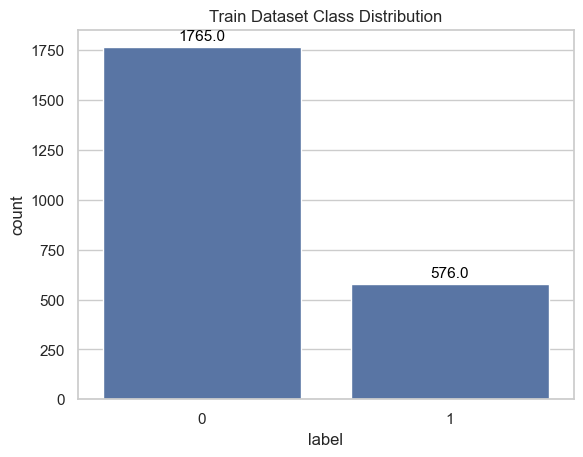

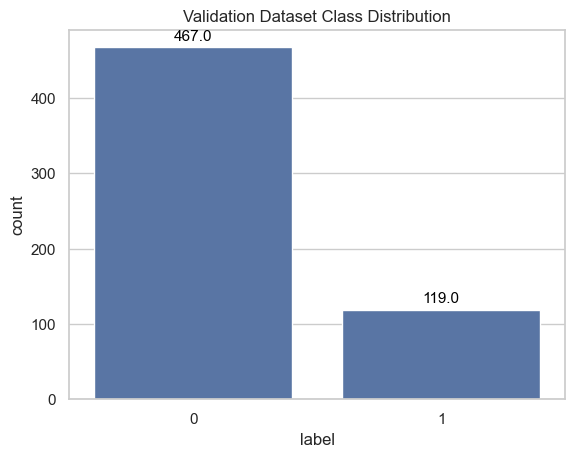

In [44]:
# plot the class distribution of train and validation set
plot_class_distribution(pd.DataFrame(y_train, columns=['label']), 'Train Dataset Class Distribution')
plot_class_distribution(pd.DataFrame(y_test, columns=['label']), 'Validation Dataset Class Distribution')

### Tokenization & Input Formatting Method 2


In [45]:
# Define hyperparameters
model_name = "monologg/kobert"
batch_size = 16 # 32, 64, 128
epochs = 1
# Lower learning rates are often better for fine-tuning transformers
learning_rate = 3e-5    #2e-5, 5e-5, 4e-5
weight_decay_rate=0.01

In [52]:
# Load KoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

#### Tokenize dataset NEW method (BARD)

In [53]:
# Preprocess training data
X_train_list = X_train.tolist()
train_inputs = tokenizer(X_train_list, padding="max_length", truncation=True, return_tensors="tf")

In [54]:
# Convert training labels to one-hot encoding
train_labels = to_categorical(y_train)

In [55]:
# Create TF training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs["input_ids"], train_labels)).batch(batch_size)

In [56]:
# Preprocess test data
X_test_list = X_train.tolist()
test_inputs = tokenizer(X_test_list, padding="max_length", truncation=True, return_tensors="tf")

In [57]:
# Convert test labels to one-hot encoding
test_labels = to_categorical(y_test)

#### Training the KoBERT model

In [65]:
# 내가 추가한거
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [66]:
# Define optimizer, loss function, and metrics
optimizer = AdamWeightDecay(learning_rate=learning_rate)      # No loss argument!
# optimizer1 = AdamW(learning_rate=learning_rate)
optimizer2 = Adam(learning_rate)  # No loss argument!

loss_fn = SparseCategoricalCrossentropy(from_logits=True)

metrics = tf.keras.metrics.SparseCategoricalAccuracy()

In [67]:
# from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
# early_stopping = EarlyStopping(monitor="val_loss", patience=3)
# model_checkpoint = ModelCheckpoint("best_model.hdf5", monitor="val_accuracy", save_best_only=True)

In [68]:
# Load pretrained KoBERT model
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
# Fine-tune the model
model.compile(optimizer=optimizer)

In [70]:
# get the model details
# get_model_details(model)

In [71]:
# get the model settings and parameters
# get_model_settings(model)

In [78]:
# [1] test 데이터 토크나이징 (return Tensors = False)
test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

# [2] tf.data.Dataset으로 만들기
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test  # 이미 정수 인코딩된 라벨이어야 함
))

# [3] 배치 처리
test_dataset = test_dataset.batch(batch_size)

In [82]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_inputs['input_ids'],
        'attention_mask': train_inputs['attention_mask'],
        'token_type_ids': train_inputs['token_type_ids']
    },
    train_labels
)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_inputs['input_ids'],
        'attention_mask': test_inputs['attention_mask'],
        'token_type_ids': test_inputs['token_type_ids']
    },
    test_labels
)).batch(batch_size)

In [86]:
from sklearn.model_selection import train_test_split

# 1. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# 2. 토크나이징
train_inputs = tokenizer(
    X_train.tolist(),
    max_length=512,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
test_inputs = tokenizer(
    X_test.tolist(),
    max_length=512,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# 3. Tensorflow Dataset 생성
batch_size = 16  # 원하는 배치 사이즈로 조절 가능

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_inputs['input_ids'],
        'attention_mask': train_inputs['attention_mask'],
        'token_type_ids': train_inputs['token_type_ids']
    },
    y_train
)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_inputs['input_ids'],
        'attention_mask': test_inputs['attention_mask'],
        'token_type_ids': test_inputs['token_type_ids']
    },
    y_test
)).batch(batch_size)

# 4. 모델 학습
epochs = 3  # 원하는 만큼
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset
)

Epoch 1/3
147/147 [==============================] - 38283s 262s/step - loss: 0.0574 - val_loss: 0.0023
Epoch 2/3
147/147 [==============================] - 15853s 108s/step - loss: 0.0016 - val_loss: 8.2857e-04
Epoch 3/3
147/147 [==============================] - 16305s 111s/step - loss: 6.7707e-04 - val_loss: 4.5213e-04


In [89]:
model.save_pretrained("./saved_model")

In [91]:
import os

save_path = "./saved_model"
os.makedirs(save_path, exist_ok=True)

# tokenizer 저장
tokenizer.save_vocabulary(save_path)

('./saved_model\\tokenizer_78b3253a26.model', './saved_model\\vocab.txt')

In [100]:
import os
print(os.getcwd())

C:\Users\hye42\Korean_Voice_Phishing_Detection\KoBERT


In [101]:
import sys
sys.path.append('..')  # 현재 디렉토리를 모듈 검색 경로에 추가

from tokenization_kobert import KoBertTokenizer # ✅ 직접 불러오기

In [109]:
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

# 모델과 토크나이저 불러오기
model = TFAutoModelForSequenceClassification.from_pretrained("./saved_model")
tokenizer = KoBertTokenizer(
    vocab_file="./saved_model/tokenizer_78b3253a26.model",
    vocab_txt="C:/Users/hye42/Korean_Voice_Phishing_Detection/KoBERT/saved_model/vocab.txt"
)

def predict(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=512)
    outputs = model(inputs)
    logits = outputs.logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    confidence = tf.nn.softmax(logits, axis=1).numpy()[0][predicted_class]
    return {
        "prediction": int(predicted_class),
        "confidence": float(confidence)
    }

Some layers from the model checkpoint at ./saved_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [110]:
print(predict("이 계좌로 입금해주시면 됩니다"))  # 예시 문장

{'prediction': 1, 'confidence': 0.9993605017662048}


In [113]:
print(predict("엄마 나 해민인데 나 카드 놓고와서 이계좌로 500만원만, 이거 지금 안 주면 나 신용불량자 됨 ㅠ"))

{'prediction': 1, 'confidence': 0.9994959831237793}


In [114]:
print(predict("안녕 혜원아 뭐하니"))

{'prediction': 1, 'confidence': 0.9991216063499451}


In [115]:
print(predict("내일 점심 라멘 먹을까 떡볶이 먹을까 ? 라멘은 3000원 떡볶이는 5000원"))

{'prediction': 1, 'confidence': 0.9688721895217896}


In [133]:
print(predict("드라마 추천좀"))

{'prediction': 1, 'confidence': 0.9300678968429565}


In [87]:
# Train the model
# history = model.fit(train_dataset, epochs=epochs, validation_data=(test_inputs["input_ids"], test_labels))

# history = model.fit(train_dataset, epochs=epochs, validation_data=(test_inputs["input_ids"], test_labels))
# history = model.fit(train_dataset)

#### Tokenize dataset OLD method

In [ ]:
# # Tokenize all of the sentences and map the tokens to thier word IDs.
# # Map to the expected input to TFBertForSequenceClassification, see https://huggingface.co/transformers/model_doc/bert.html#tfbertforsequenceclassification
# train_input_ids = []
# train_attention_masks = []
# 
# validation_input_ids = []
# validation_attention_masks = []
# 
# # For every sentence...
# for train_sent, validation_sent in zip(train_inputs, validation_inputs):
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
#     train_encoded_dict = tokenizer1.encode_plus(
#                         train_sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 64,           # Pad & truncate all sentences.
#                         padding='max_length',
#                         return_attention_mask = True,   # Construct attn. masks.
#                         truncation=True,
#                         return_tensors = 'tf',     # Return tensorflow tensor.
#                    )
#     validation_encoded_dict = tokenizer1.encode_plus(
#                         validation_sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 64,           # Pad & truncate all sentences.
#                         padding='max_length',
#                         return_attention_mask = True,   # Construct attn. masks.
#                         truncation=True,
#                         return_tensors = 'tf',     # Return tensorflow tensor.
#                    )
#     
#     # Add the encoded sentence to the list.    
#     train_input_ids.append(train_encoded_dict['input_ids'])
#     train_attention_masks.append(train_encoded_dict['attention_mask'])
#     validation_input_ids.append(validation_encoded_dict['input_ids'])
#     validation_attention_masks.append(validation_encoded_dict['attention_mask'])

In [ ]:
# # Convert the lists into tensors.
# train_input_ids = tf.convert_to_tensor(train_input_ids)
# train_attention_masks = tf.convert_to_tensor(train_attention_masks)
# train_labels = tf.convert_to_tensor(train_labels)
# 
# validation_input_ids = tf.convert_to_tensor(validation_input_ids)
# validation_attention_masks = tf.convert_to_tensor(validation_attention_masks)
# validation_labels = tf.convert_to_tensor(validation_labels)
# 
# # Print sentence 0, now as a list of IDs.
# print('Original: ', train_inputs[0])
# print('Token IDs:', train_input_ids[0])

In [ ]:
# # prepare the dataset for training
# train_dataset = tf.data.Dataset.from_tensor_slices((train_input_ids, train_attention_masks, train_labels))
# validation_dataset = tf.data.Dataset.from_tensor_slices((validation_input_ids, validation_attention_masks, validation_labels))

In [ ]:
# # shuffle the dataset
# train_dataset = train_dataset.shuffle(len(train_input_ids)).batch(32)
# validation_dataset = validation_dataset.shuffle(len(validation_input_ids)).batch(32)

In [ ]:
# # print the shape of the dataset
# print(train_dataset)
# print(validation_dataset)

#### Train the korean BERT model

In [ ]:
# #Function to get all the model settings and parameters
# def get_model_settings(model):
#     print('Model Name: ', model.name_or_path)
#     print('Model Type: ', model.__class__)
#     print('Model Parameters: ', model.config)
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_pretrained_dict())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_pretrained_dict())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_pretrained_dict())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_pretrained_dict())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_pretrained_dict())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())


In [ ]:
# # function to get the model detail after compiling
# def get_model_details(model):
#     print('Model Name: ', model.name)
#     print('Model Type: ', model.__class__)
#     print('Model Parameters: ', model.count_params())
#     print('Model Parameters: ', model.summary())
#     # print('Model Parameters: ', model.weights)
#     # print('Model Parameters: ', model.trainable_weights)
#     # print('Model Parameters: ', model.non_trainable_weights)
#     # print('Model Parameters: ', model.layers)
#     # print('Model Parameters: ', model.layers[0].name)
#     # print('Model Parameters: ', model.layers[0].trainable)
#     # print('Model Parameters: ', model.layers[0].count_params())
#     # print('Model Parameters: ', model.layers[0].input_shape)
#     # print('Model Parameters: ', model.layers[0].output_shape)
#     # print('Model Parameters: ', model.layers[0].get_weights())
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].shape)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].shape)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0])
#     # print('Model Parameters: ', model.layers[0].get_weights()[1])
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].size)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].size)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].nbytes)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].nbytes)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].itemsize)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].itemsize)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].dtype)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].dtype)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].ndim)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].ndim)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].shape)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].shape)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].flatten())
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].flatten().shape)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].flatten())
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].flatten().shape)  
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].flatten().size)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].flatten().size)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].flatten().nbytes)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].flatten().nbytes)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].flatten().itemsize)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].flatten().itemsize)   

In [ ]:
# # Load the pre-trained KoBERT model
# model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2, from_pt=True)

In [ ]:

# model1 = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, from_pt=True)

In [ ]:
# model0 = TFBertModel.from_pretrained(model_name, from_pt=True,num_labels=2)

In [ ]:
# model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [ ]:
# # Get the model settings and parameters
# get_model_settings(model)
# print('#'*100)

In [ ]:
# # Get the model settings and parameters
# get_model_settings(model1)
# print('#'*100)

In [ ]:
# # Get the model settings and parameters
# get_model_settings(model0)
# print('#'*100)

In [ ]:
# # Get the model settings and parameters
# get_model_settings(model2)
# print('#'*100)

In [ ]:
# compare all the models parameters
# model.config == model1.config == model0.config == model2.config

In [ ]:
# # Define model hyperparameters
# batch_size = 32
# # epochs = 5
# # Lower learning rates are often better for fine-tuning transformers
# learning_rate = 3e-5    #2e-5, 5e-5, 4e-5 
# weight_decay_rate=0.01
# 
# # Define the optimizer
# optimizer = AdamWeightDecay(learning_rate=learning_rate)      # No loss argument!

In [ ]:
# Compile the model
# model.compile(optimizer=optimizer)

In [ ]:
# Get the model details
# get_model_details(model)

In [ ]:
# # train the model
# history = model.fit(x={'input_ids': train_input_ids, 'attention_mask': train_attention_masks},
#                     y=train_labels,
#                     # batch_size=batch_size,
#                     # epochs=epochs,
#                     validation_data=({'input_ids': validation_input_ids, 'attention_mask': validation_attention_masks}, validation_labels))


In [ ]:
# model.fit(tokenized_data, labels)

In [ ]:
# # Fucntion to get all the model parameters and their shape and size in MB 
# def get_model_memory_usage(batch_size, mymodel):
#     shapes_mem_count = 0
#     for p in mymodel.trainable_weights:
#         shapes_mem_count += np.prod(p.shape)
#     # shapes_mem_count *= batch_size
#     # shapes_mem_count *= 4  # fp32 bits/element
#     # shapes_mem_count /= 1024**2
#     # print('Model size (MB):', shapes_mem_count)
#     return shapes_mem_count

In [ ]:
# #put the bellow in a function
# def mode_info(model):
#     model.config
#     # Getthe model weights
#     model.get_weights()
#     # Getthe model summary
#     model.summary()
#     # Getthe model layers
#     model.layers
#     # Getthe model input
#     model.input
#     # Getthe model output
#     model.output
#     # Getthe model loss
#     model.loss
#     # Getthe model metrics
#     model.metrics
#     # Getthe model optimizer
#     model.optimizer
#     # Getthe model sample weight mode
#     model.sample_weight_mode